 # Image Captioning 

 
   # What is Image Captioning?
   Image Captioning is the process of generating textual description of an image. It uses         both Natural Language Processing and Computer Vision to generate the captions.

![](https://i.imgur.com/tVtHhNp.png)

# Image Encoder, Text Decoder
Since we have a separate encoder and decoder, we could also have an encoder that encodes images, and a decoder that decodes text, giving us an image captioning model.

![](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

# Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Import Data_DIR , Work_DIR

In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

# extract features from image

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

# store features in pickle

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, '/kaggle/input/features/features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [2]:
len(mapping)

NameError: name 'mapping' is not defined

# Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

In [3]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

NameError: name 'mapping' is not defined

In [68]:
len(all_captions)

40455

In [69]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [70]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [71]:
vocab_size

8485

In [72]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [74]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [83]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [20]:
# loading the model

import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/kaggle/input/models/best_model_150epoch_continue_training.h5')

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      2172160     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
____________________________________________________________________________________________

In [42]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Attention, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Image feature branch
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)  # Increased dropout
fe2 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fe1)  # L2 regularization

# Sequence branch
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)  # Increased dropout
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)  # Bidirectional LSTM

# Attention mechanism
attention = Attention()([se3, se3])  # Self-attention
se4 = LSTM(256)(attention)  # Second LSTM layer

# Decoder
decoder1 = add([fe2, se4])  # Combine features
decoder2 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(decoder1)  # Regularized
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [43]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile with Adam and lower initial LR
optimizer = Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

In [ ]:
epochs = 50  # Increased due to early stopping
batch_size = 16  # Reduced for better generalization

# Data generators (same as before but with new batch_size)
train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(train)//batch_size,
    validation_steps=len(test)//batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
455/455 [==============================] - 129s 263ms/step - loss: 9.5794 - accuracy: 0.1187 - val_loss: 7.0744 - val_accuracy: 0.1398
Epoch 2/50


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


455/455 [==============================] - 116s 256ms/step - loss: 6.2406 - accuracy: 0.1573 - val_loss: 5.6813 - val_accuracy: 0.1756
Epoch 3/50
455/455 [==============================] - 116s 256ms/step - loss: 5.3184 - accuracy: 0.1873 - val_loss: 5.1301 - val_accuracy: 0.1947
Epoch 4/50
455/455 [==============================] - 116s 255ms/step - loss: 4.8967 - accuracy: 0.2005 - val_loss: 4.8670 - val_accuracy: 0.2020
Epoch 5/50
455/455 [==============================] - 116s 256ms/step - loss: 4.6750 - accuracy: 0.2075 - val_loss: 4.7296 - val_accuracy: 0.2074
Epoch 6/50
455/455 [==============================] - 116s 255ms/step - loss: 4.5336 - accuracy: 0.2143 - val_loss: 4.6411 - val_accuracy: 0.2134
Epoch 7/50
455/455 [==============================] - 116s 255ms/step - loss: 4.4316 - accuracy: 0.2222 - val_loss: 4.5715 - val_accuracy: 0.2207
Epoch 8/50
455/455 [==============================] - 117s 256ms/step - loss: 4.3533 - accuracy: 0.2299 - val_loss: 4.5224 - val_accura

In [ ]:
model.save('upgraded_cap_gen.h5')

In [40]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


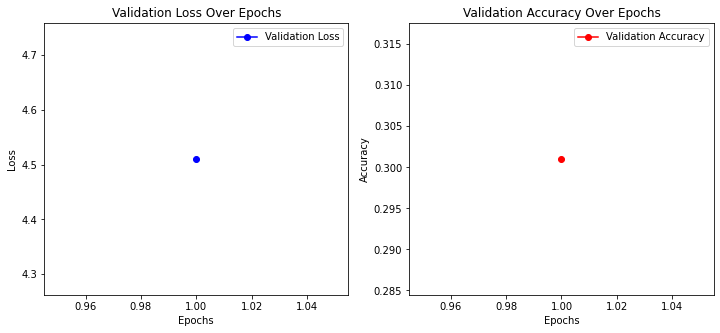

In [41]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots validation loss and validation accuracy over epochs."""
    epochs = range(1, len(history.history['val_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['val_loss'], 'bo-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.show(block=True)  # Force the plot to display

# Call this after training
plot_training_history(history)


# Generate Captions for the Image

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [77]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [78]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = list(), list()
skipped = 0

for key in tqdm(test):
    # Skip if key not in features
    if key not in features:
        skipped += 1
        continue
        
    # Get feature and validate shape
    feature = np.array(features[key])
    if feature.size != 4096:
        skipped += 1
        continue
        
    # Reshape properly
    try:
        feature = feature.reshape(1, 4096)
        
        # Get actual captions
        captions = mapping[key]
        
        # Predict caption
        y_pred = predict_caption(model, feature, tokenizer, max_length)
        
        # Process captions
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        
        # Append to lists
        actual.append(actual_captions)
        predicted.append(y_pred)
        
    except Exception as e:
        print(f"Error processing {key}: {str(e)}")
        skipped += 1
        continue

print(f"Skipped {skipped} problematic samples")

# Calculate BLEU scores
if len(actual) > 0:
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
else:
    print("No valid predictions were made")

100%|██████████| 810/810 [13:04<00:00,  1.03it/s]


Skipped 0 problematic samples
BLEU-1: 0.567259
BLEU-2: 0.346362


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the grass endseq


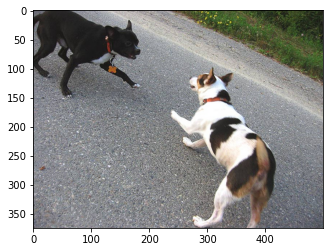

In [25]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------------Predicted--------------------
startseq man in black shirt is standing on the street with his arms out endseq


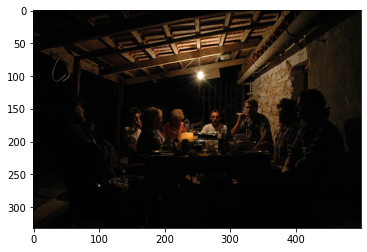

In [26]:
generate_caption("107582366_d86f2d3347.jpg")

---------------------Actual---------------------
startseq family playing on tractor on beautiful day endseq
startseq children ride tractor in field endseq
startseq several children playing on polaris vehicle outdoors endseq
startseq the children played on the four wheeler in the field endseq
startseq the four kids are riding on an atv in field endseq
--------------------Predicted--------------------
startseq two people on red atv ride endseq


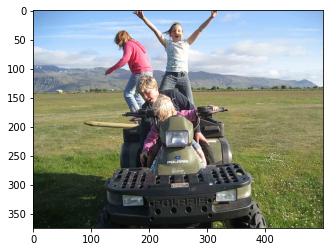

In [32]:
generate_caption("1087539207_9f77ab3aaf.jpg")

In [33]:
import matplotlib.pyplot as plt

# Extract validation loss
val_loss = history.history['val_loss']

# Plot validation loss
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


KeyError: 'val_loss'

In [35]:
history.history.keys()

dict_keys(['loss'])

In [28]:
# load vgg16 model
model2= VGG16()
# restructure the model
model2 = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)
# summarize
#print(model2.summary())

--------------------Predicted--------------------
startseq the man is sitting on the sand with his hair endseq


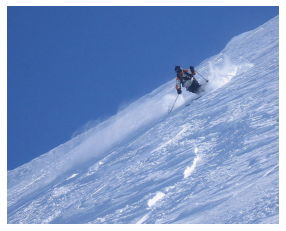

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Function to preprocess image for CNN model
def preprocess_image(image_path, target_size=(224, 224)):  # Change target_size if your CNN requires different
    image = load_img(image_path, target_size=target_size)  # Load image
    image = img_to_array(image) / 255.0  # Normalize (if required by CNN)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load test image
image_path = "/kaggle/input/testing123/test9.jpg"  # Replace with your image path
image = load_img(image_path)  # Load for displaying

# Extract features using the trained CNN model
image_input = preprocess_image(image_path)
features = model2.predict(image_input)  # cnn_model should be your trained feature extractor

# Predict caption using the extracted features
y_pred = predict_caption(model, features, tokenizer, max_length)  # Your captioning function

# Display results
print('--------------------Predicted--------------------')
print(y_pred)
plt.imshow(image)
plt.axis("off")
plt.show()


In [85]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# 1. Define your data generators first
def create_generators():
    # Create train generator (replace with your actual data loading logic)
    train_generator = data_generator(
        train, mapping, features, tokenizer,
        max_length=max_length, vocab_size=vocab_size, batch_size=32
    )
    
    # Create validation subset generator
    val_keys_subset = list(test)[:500]  # Use first 500 for faster validation
    val_generator_fast = data_generator(
        val_keys_subset, mapping, features, tokenizer,
        max_length=max_length, vocab_size=vocab_size, batch_size=32
    )
    return train_generator, val_generator_fast

# 2. Model building function
def build_model(hp):
    # Image feature branch
    inputs1 = layers.Input(shape=(4096,))
    fe1 = layers.Dropout(hp.Float('img_dropout', 0.3, 0.6))(inputs1)
    img_units = hp.Choice('img_units', [256, 512])  # Reduced choices for speed
    fe2 = layers.Dense(
        img_units,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(hp.Float('img_l2', 1e-4, 1e-2))
    )(fe1)

    # Sequence branch
    inputs2 = layers.Input(shape=(max_length,))
    se1 = layers.Embedding(
        vocab_size, 
        hp.Choice('embed_dim', [256, 512]),
        mask_zero=True
    )(inputs2)
    se2 = layers.Dropout(hp.Float('seq_dropout', 0.3, 0.6))(se1)
    
    # Use same units for both LSTM layers
    lstm_units = hp.Choice('lstm_units', [256, 512])
    se3 = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True)
    )(se2)
    
    attention = layers.Attention()([se3, se3])
    se4 = layers.LSTM(lstm_units)(attention)

    # Ensure compatible shapes
    if img_units != lstm_units:
        fe2 = layers.Dense(lstm_units)(fe2)
    
    decoder1 = layers.add([fe2, se4])
    decoder2 = layers.Dense(
        hp.Choice('decoder_units', [256, 512]),
        activation='relu'
    )(decoder1)
    outputs = layers.Dense(vocab_size, activation='softmax')(decoder2)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-3)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3. Initialize and run the tuner
def run_tuning():
    train_gen, val_gen = create_generators()
    
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=8,  # Reduced for speed
        executions_per_trial=1,
        directory='fast_tuning',
        project_name='caption_gen',
        overwrite=True
    )
    
    tuner.search(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[keras.callbacks.EarlyStopping(patience=2)],
        steps_per_epoch=100,
        validation_steps=50
    )
    
    return tuner

# 4. Execute the tuning
tuner = run_tuning()

# 5. Get and save results
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

best_model = tuner.get_best_models()[0]
best_model.save('best_tuned_model.h5')


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.45114           |?                 |img_dropout
512               |?                 |img_units
0.0065146         |?                 |img_l2
256               |?                 |embed_dim
0.31435           |?                 |seq_dropout
512               |?                 |lstm_units
256               |?                 |decoder_units
0.00094301        |?                 |learning_rate

Epoch 1/5
  1/100 [..............................] - ETA: 1:01:37 - loss: 15.0848 - accuracy: 0.0000e+00

KeyboardInterrupt: 

### 